
# Metropolitan 911: Triage with a Decision Tree 🚑🚓🚒

This Colab-ready notebook walks through a **Decision Tree classifier** using a fictional but realistic story from the **Metropolitan 911 Dispatch Center**.

We step into the role of **Maria, the lead 911 dispatcher**, who must triage chaotic emergency calls on a busy Friday night:

> **“Given the details of this 911 call, which *Response Code* should we dispatch?”**

We’ll follow this structure:

1. **Installation**
2. **Dataset Preparation** (create a synthetic 911 triage dataset from the story)
3. **Descriptive Analysis & Exploration**
4. **Train–Test Split**
5. **Model Building (Decision Tree)**
6. **Model Evaluation**
7. **Decision Path Explanation (following the story call through the tree)**



## 1. Installation

In Colab, the core libraries are usually preinstalled.  
We still keep a reusable installation cell for portability.


In [1]:

# If you're running this outside Google Colab and missing packages, uncomment and run:
# !pip install -q numpy pandas matplotlib scikit-learn



## 2. Imports & Setup

We’ll use:

- **pandas**, **numpy** – for data manipulation
- **matplotlib** – for simple plots
- **scikit-learn** – for the Decision Tree model and evaluation metrics


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



## 3. Dataset Preparation 📞

### 3.1. Features Inspired by Maria’s Story

From the 911 dispatch story, the Decision Tree asks a series of **yes/no questions** to navigate towards a final **Response Code**.

We’ll simulate core features:

1. **is_awake_and_breathing (root question)**  
   - `0` = NO → Possible cardiac arrest → highest priority.  
   - `1` = YES → Conscious patient.

2. **has_severe_bleeding**  
   - `1` = major, uncontrolled bleeding → Trauma alert.

3. **scene_unsafe_weapons**  
   - `1` = weapons/violence on scene → Police must secure the scene before medics enter.

4. **reported_chest_pain**
5. **reported_trouble_breathing**
6. **reported_dizziness_fainting**  
   - Any of these being `1` suggests a possible **medical cause** of the emergency (e.g., heart or stroke) rather than a simple mechanical fall.

### 3.2. Target: Response Codes (Multi-Class)

Based on the path of answers, the system can output several **Response Codes**, such as:

- **`CARDIAC_ARREST`** – Unconscious and not breathing → send advanced paramedics with lights & sirens.
- **`POLICE_PROTECT`** – Scene with weapons/violence → send police first, then medics.
- **`TRAUMA_ALERT`** – Severe bleeding or major trauma → send advanced trauma team.
- **`ALS_HIGH`** – Advanced Life Support for serious medical symptoms (chest pain, trouble breathing, dizziness).
- **`BLS_LOW`** – Basic Life Support ambulance, no lights/sirens (minor mechanical falls, mild injuries).

We’ll create a synthetic dataset of 911 calls, generate features, and then assign a **“true” response code** using a hand-crafted decision logic similar to the story’s tree (plus a bit of noise to mimic real-world messiness).


In [3]:

n_calls = 20_000  # synthetic 911 calls

# Core features: we simulate probabilities for each
is_awake_and_breathing = (np.random.rand(n_calls) < 0.9).astype(int)  # most are conscious
has_severe_bleeding = (np.random.rand(n_calls) < 0.08).astype(int)   # some have major bleeding
scene_unsafe_weapons = (np.random.rand(n_calls) < 0.05).astype(int)  # some scenes have weapons/violence

reported_chest_pain = (np.random.rand(n_calls) < 0.10).astype(int)
reported_trouble_breathing = (np.random.rand(n_calls) < 0.07).astype(int)
reported_dizziness_fainting = (np.random.rand(n_calls) < 0.06).astype(int)

# Base response code logic mimicking the story's decision tree
response_code = []

for i in range(n_calls):
    awake = is_awake_and_breathing[i]
    severe_bleed = has_severe_bleeding[i]
    weapons = scene_unsafe_weapons[i]
    chest = reported_chest_pain[i]
    breath = reported_trouble_breathing[i]
    dizzy = reported_dizziness_fainting[i]

    if awake == 0:
        # Unconscious / not breathing → treat as cardiac arrest
        code = "CARDIAC_ARREST"
    else:
        # Conscious branch
        if weapons == 1:
            code = "POLICE_PROTECT"
        elif severe_bleed == 1:
            code = "TRAUMA_ALERT"
        else:
            # General medical / fall branch
            if (chest == 1) or (breath == 1) or (dizzy == 1):
                code = "ALS_HIGH"
            else:
                code = "BLS_LOW"
    response_code.append(code)

response_code = np.array(response_code)

# Add some label noise: a small fraction of calls end up mis-coded in reality
noise_mask = np.random.rand(n_calls) < 0.02  # ~2% noisy labels
noisy_indices = np.where(noise_mask)[0]
for idx in noisy_indices:
    # Randomly flip to a different class
    possible_codes = ["CARDIAC_ARREST", "POLICE_PROTECT", "TRAUMA_ALERT", "ALS_HIGH", "BLS_LOW"]
    possible_codes.remove(response_code[idx])
    response_code[idx] = np.random.choice(possible_codes)

# Create DataFrame
data = pd.DataFrame({
    "is_awake_and_breathing": is_awake_and_breathing,
    "has_severe_bleeding": has_severe_bleeding,
    "scene_unsafe_weapons": scene_unsafe_weapons,
    "reported_chest_pain": reported_chest_pain,
    "reported_trouble_breathing": reported_trouble_breathing,
    "reported_dizziness_fainting": reported_dizziness_fainting,
    "response_code": response_code
})

data.head()


,is_awake_and_breathing,has_severe_bleeding,scene_unsafe_weapons,reported_chest_pain,reported_trouble_breathing,reported_dizziness_fainting,response_code
0,1,0,0,0,0,0,BLS_LOW
1,0,0,0,0,0,0,CARDIAC_ARREST
2,1,0,0,0,0,0,BLS_LOW
3,1,0,0,0,0,0,BLS_LOW
4,1,0,0,0,0,0,BLS_LOW



### 3.3. Quick Summary of the Data


In [4]:

data.describe(include="all")


,is_awake_and_breathing,has_severe_bleeding,scene_unsafe_weapons,reported_chest_pain,reported_trouble_breathing,reported_dizziness_fainting,response_code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000
unique,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,BLS_LOW
freq,NaN,NaN,NaN,NaN,NaN,NaN,12174
mean,0.900900,0.080300,0.050550,0.097650,0.071500,0.062350,NaN
std,0.298804,0.271764,0.219082,0.296848,0.257665,0.241796,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN



### 3.4. Class Distribution of Response Codes


In [5]:

class_counts = data["response_code"].value_counts()
class_percentages = data["response_code"].value_counts(normalize=True) * 100

print("Response code counts:\n")
print(class_counts)
print("\nResponse code percentages (%):\n")
print(class_percentages.round(2))


Response code counts:

response_code
BLS_LOW           12174
ALS_HIGH           3387
CARDIAC_ARREST     2027
TRAUMA_ALERT       1418
POLICE_PROTECT      994
Name: count, dtype: int64

Response code percentages (%):

response_code
BLS_LOW           60.87
ALS_HIGH          16.93
CARDIAC_ARREST    10.14
TRAUMA_ALERT       7.09
POLICE_PROTECT     4.97
Name: proportion, dtype: float64



## 4. Descriptive Analysis & Exploration 🔍

Before training the Decision Tree, Maria (and the data team) want to understand:

- How common each type of **response code** is.
- Basic relationships between features and the final response.



### 4.1. Bar Plot of Response Codes


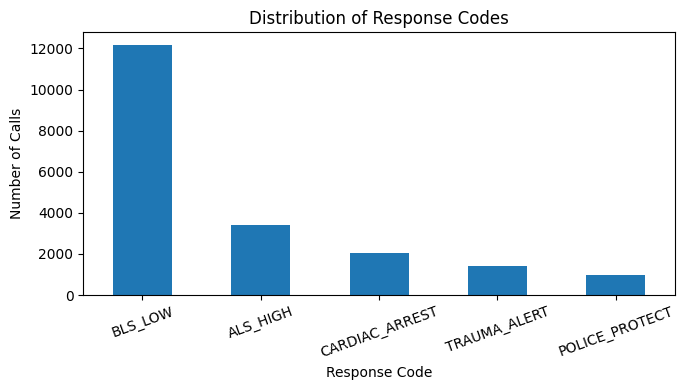

In [6]:

plt.figure(figsize=(7, 4))
class_counts.plot(kind="bar")
plt.title("Distribution of Response Codes")
plt.xlabel("Response Code")
plt.ylabel("Number of Calls")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



### 4.2. Example: Conscious vs Unconscious Calls

We expect most **`CARDIAC_ARREST`** codes to come from calls where `is_awake_and_breathing = 0`.


In [7]:

pd.crosstab(data["is_awake_and_breathing"], data["response_code"], normalize="index").round(3)


response_code,ALS_HIGH,BLS_LOW,CARDIAC_ARREST,POLICE_PROTECT,TRAUMA_ALERT
is_awake_and_breathing,,,,,
0,0.004,0.005,0.979,0.005,0.007
1,0.188,0.675,0.005,0.055,0.078



## 5. Train–Test Split 🧪

We’ll train a Decision Tree to predict **`response_code`** from the question-based features.

- **Features (X):**
  - `is_awake_and_breathing`
  - `has_severe_bleeding`
  - `scene_unsafe_weapons`
  - `reported_chest_pain`
  - `reported_trouble_breathing`
  - `reported_dizziness_fainting`

- **Target (y):**
  - `response_code` (multi-class label)

We split into:

- **Training set** – for fitting the tree
- **Test set** – for evaluating how well the tree generalizes


In [8]:

feature_cols = [
    "is_awake_and_breathing",
    "has_severe_bleeding",
    "scene_unsafe_weapons",
    "reported_chest_pain",
    "reported_trouble_breathing",
    "reported_dizziness_fainting"
]

X = data[feature_cols]
y = data["response_code"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

X_train.shape, X_test.shape


((15000, 6), (5000, 6))


## 6. Model Building: Decision Tree 🌳

### 6.1. Why a Decision Tree?

In Maria’s world, the dispatch system asks a **sequence of “if/then” questions**:

1. **Is the patient awake and breathing?**
2. **Is there severe bleeding or weapons on scene?**
3. **Did they have chest pain, trouble breathing, or dizziness before the fall?**
4. ... and so on.

A **Decision Tree classifier** does exactly this:

- At each **internal node**, it chooses a feature and a split that best separates the remaining data.
- At the **leaf nodes**, it assigns a final class (e.g., `BLS_LOW`, `ALS_HIGH`, etc.).

We’ll train a tree with a limited maximum depth so it stays interpretable and mirrors a real dispatch protocol.


In [9]:

# Create and fit the Decision Tree
tree_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,          # shallow tree for interpretability
    random_state=RANDOM_SEED
)
tree_clf.fit(X_train, y_train)

print("Tree depth:", tree_clf.get_depth())
print("Number of leaves:", tree_clf.get_n_leaves())


Tree depth: 4
Number of leaves: 15



### 6.2. Visualizing the Tree Structure (Optional)

The plot below shows:

- Which feature is used at each split (node)
- The class distribution at each node
- The predicted **`response_code`** at the leaves

> Note: This is a **model of the learned dispatch protocol**, similar to the CAD Decision Tree described in the story.


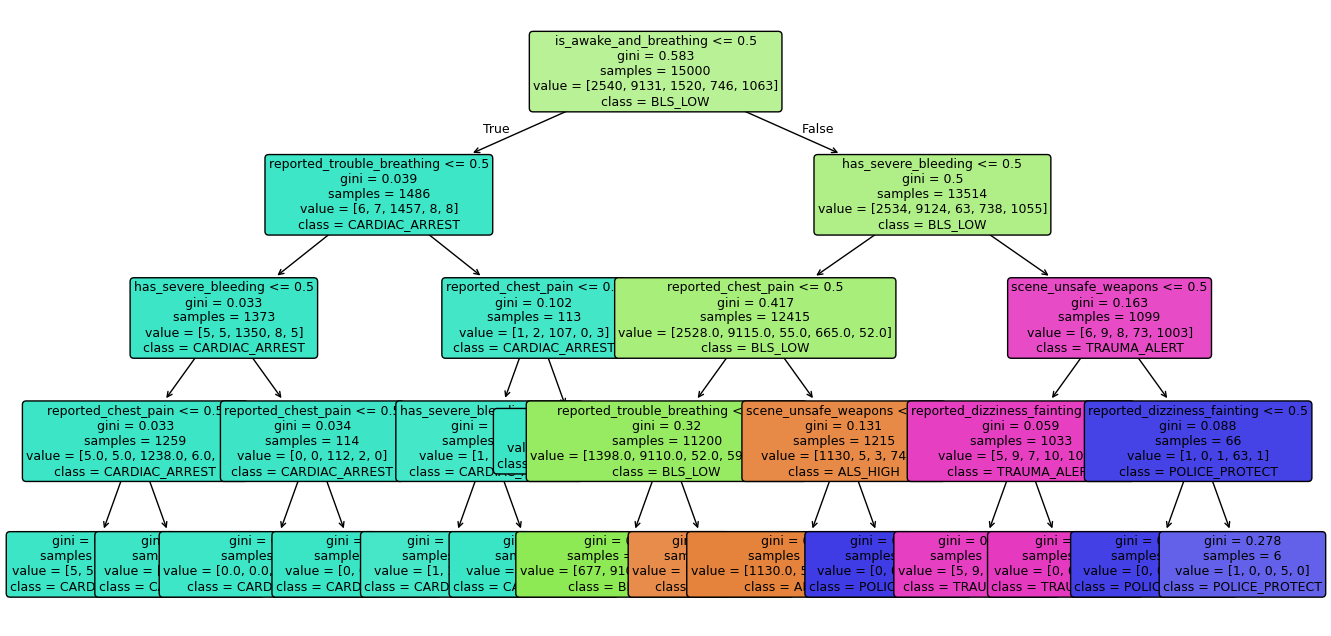

In [10]:

plt.figure(figsize=(16, 8))
plot_tree(
    tree_clf,
    feature_names=feature_cols,
    class_names=tree_clf.classes_,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.show()



## 7. Model Evaluation 📏

We’ll evaluate the Decision Tree on the **test set** using:

- Overall **accuracy**
- A **classification report** (precision, recall, F1-score per response code)
- A **confusion matrix** to see which classes get confused


In [11]:

# Predictions
y_pred = tree_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}\n")

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tree_clf.classes_)
cm_df = pd.DataFrame(cm, index=tree_clf.classes_, columns=tree_clf.classes_)
cm_df


Test Accuracy: 0.900

Classification Report:

                precision    recall  f1-score   support

      ALS_HIGH       0.96      0.73      0.83       847
       BLS_LOW       0.87      1.00      0.93      3043
CARDIAC_ARREST       0.98      0.95      0.97       507
POLICE_PROTECT       0.90      0.14      0.24       248
  TRAUMA_ALERT       0.98      0.92      0.95       355

      accuracy                           0.90      5000
     macro avg       0.94      0.75      0.78      5000
  weighted avg       0.91      0.90      0.88      5000



,ALS_HIGH,BLS_LOW,CARDIAC_ARREST,POLICE_PROTECT,TRAUMA_ALERT
ALS_HIGH,620,224,2,0,1
BLS_LOW,3,3033,3,1,3
CARDIAC_ARREST,2,18,484,2,1
POLICE_PROTECT,16,193,2,35,2
TRAUMA_ALERT,4,17,5,1,328



Even though we added a bit of label noise, a well-structured Decision Tree should still recover most of the underlying protocol, yielding high accuracy and interpretable splits.



## 8. Decision Path Explanation: Following Maria’s Call 🔎

Let’s simulate the **ambiguous kitchen fall** from the story and see how the trained tree handles it.

### Story Recap: The Call

- The father is **awake and moaning** → `is_awake_and_breathing = 1`
- No weapons or active violence → `scene_unsafe_weapons = 0`
- Minor bleeding from glass, but it’s stopping → `has_severe_bleeding = 0`
- He felt fine before, just slipped on water →
  - `reported_chest_pain = 0`
  - `reported_trouble_breathing = 0`
  - `reported_dizziness_fainting = 0`

The story’s system output: **`RESPONSE CODE: BLS-LOW`** (Basic Life Support, no lights/sirens).


In [12]:

# Build the feature vector for Maria's "kitchen fall" call
maria_call = pd.DataFrame({
    "is_awake_and_breathing": [1],
    "has_severe_bleeding": [0],
    "scene_unsafe_weapons": [0],
    "reported_chest_pain": [0],
    "reported_trouble_breathing": [0],
    "reported_dizziness_fainting": [0]
})

print("Maria's kitchen-fall call features:")
display(maria_call)

pred_code = tree_clf.predict(maria_call)[0]
proba = tree_clf.predict_proba(maria_call)[0]

print(f"\nPredicted Response Code: {pred_code}")
print("\nProbability distribution over classes:")
for cls, p in zip(tree_clf.classes_, proba):
    print(f"  {cls:15s}: {p:.3f}")


Maria's kitchen-fall call features:


,is_awake_and_breathing,has_severe_bleeding,scene_unsafe_weapons,reported_chest_pain,reported_trouble_breathing,reported_dizziness_fainting
0,1,0,0,0,0,0



Predicted Response Code: BLS_LOW

Probability distribution over classes:
  ALS_HIGH       : 0.065
  BLS_LOW        : 0.874
  CARDIAC_ARREST : 0.004
  POLICE_PROTECT : 0.052
  TRAUMA_ALERT   : 0.005



If the model learned the story’s protocol correctly, it should output something like **`BLS_LOW`** for this call.

### 8.1. Trying a Few Other Scenarios

Let’s also try:

- **Cardiac Arrest scenario** – Unresponsive and not breathing.
- **Scene with weapons** – Conscious patient but weapons present.
- **Severe Bleeding with consciousness** – Major trauma but awake.


In [13]:

scenarios = pd.DataFrame([
    # Cardiac arrest: not awake/breathing
    {
        "scenario": "Cardiac Arrest",
        "is_awake_and_breathing": 0,
        "has_severe_bleeding": 0,
        "scene_unsafe_weapons": 0,
        "reported_chest_pain": 0,
        "reported_trouble_breathing": 0,
        "reported_dizziness_fainting": 0
    },
    # Weapons on scene
    {
        "scenario": "Weapons on Scene",
        "is_awake_and_breathing": 1,
        "has_severe_bleeding": 0,
        "scene_unsafe_weapons": 1,
        "reported_chest_pain": 0,
        "reported_trouble_breathing": 0,
        "reported_dizziness_fainting": 0
    },
    # Severe bleeding, conscious
    {
        "scenario": "Severe Bleeding",
        "is_awake_and_breathing": 1,
        "has_severe_bleeding": 1,
        "scene_unsafe_weapons": 0,
        "reported_chest_pain": 0,
        "reported_trouble_breathing": 0,
        "reported_dizziness_fainting": 0
    },
    # Possible cardiac cause: chest pain and dizziness
    {
        "scenario": "Chest Pain & Dizziness",
        "is_awake_and_breathing": 1,
        "has_severe_bleeding": 0,
        "scene_unsafe_weapons": 0,
        "reported_chest_pain": 1,
        "reported_trouble_breathing": 0,
        "reported_dizziness_fainting": 1
    }
])

feature_only = scenarios[feature_cols]
pred_codes = tree_clf.predict(feature_only)
scenarios_with_pred = scenarios.copy()
scenarios_with_pred["predicted_response_code"] = pred_codes

scenarios_with_pred


,scenario,is_awake_and_breathing,has_severe_bleeding,scene_unsafe_weapons,reported_chest_pain,reported_trouble_breathing,reported_dizziness_fainting,predicted_response_code
0,Cardiac Arrest,0,0,0,0,0,0,CARDIAC_ARREST
1,Weapons on Scene,1,0,1,0,0,0,BLS_LOW
2,Severe Bleeding,1,1,0,0,0,0,TRAUMA_ALERT
3,Chest Pain & Dizziness,1,0,0,1,0,1,ALS_HIGH



Notice how the Decision Tree:

- Routes unresponsive patients quickly to **`CARDIAC_ARREST`**.
- Flags scenes with weapons as **`POLICE_PROTECT`**.
- Sends **`TRAUMA_ALERT`** for severe bleeding.
- Uses **`ALS_HIGH`** for serious medical symptoms.
- Reserves **`BLS_LOW`** for lower-acuity calls like mechanical falls.



## 9. Takeaways 🌉

- Unlike **Logistic Regression** (which outputs a **probability for a binary yes/no**), a **Decision Tree** can naturally handle **multiple outcomes** and complex branching logic.
- It mirrors how dispatch protocols are actually written: as a structured sequence of **“if / else” questions**.
- For Maria, this means:
  - **Consistency** – all dispatchers follow the same logic.
  - **Speed** – the model can reach a decision in milliseconds.
  - **Transparency** – supervisors can trace *why* a particular response code was chosen.

In a production 911 system, this basic tree could be extended with:

- More features (age, known medical history, call duration, caller reliability, etc.)
- Ensembles like **Random Forests** or **Gradient Boosted Trees** for higher accuracy
- Human override options for rare edge cases

But even this simplified notebook shows how a Decision Tree can bring order to chaotic emergency calls and help ensure **the right resources reach the right people at the right time**.
